<div align="center"><h1>Trophic Metaweb : Interactions predictions</h1></div>

<div class="alert alert-success">

<div align = "center"><img src="./metaweb_image.png" alt="Metaweb image"/></div>

<div class="alert alert-success">

In [3]:
# imports
import os

os.environ["DGLBACKEND"] = "pytorch"

import csv
import dgl
import torch
import torch
import pickle
import itertools
import numpy as np
import pandas as pd
import networkx as nx
import torch.nn as nn
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import torch.nn.functional as F
from pyvis.network import Network
from sklearn.metrics import roc_auc_score
from dgl.dataloading import GraphDataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data.sampler import SubsetRandomSampler

### Preprocessing & Visualization

In [4]:
edges_data  = open('list_edges.csv', "r", encoding='utf8')
reader = csv.reader(edges_data)
edge_list = []
next(reader) # skip first line
for row in reader:
    edge_list.append((row[0],row[1]))

In [5]:
len(edge_list)

145677

In [6]:
G = nx.DiGraph()
G.add_edges_from(edge_list)

In [7]:
print(f"Nodes: {len(G.nodes())}, Edges: {len(G.edges())}")

Nodes: 1151, Edges: 83568


In [8]:
# Choose a subset of nodes to create a smaller graph for testing
subgraph_nodes = list(G.nodes())[:40]  # First 50 nodes for example
subgraph = G.subgraph(subgraph_nodes)

net = Network(notebook=True,cdn_resources="in_line", directed=True)
net.from_nx(subgraph)
net.force_atlas_2based()
net.save_graph("subgraph.html")

In [9]:
info_species = {}
with open('clean_species_and_taxo.csv', mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file,delimiter=";")
    line_count = 0
    next(csv_reader) #skip first row
    for row in csv_reader:
        info_species[row['Species ID']] = row

In [10]:
# Remove unnecessary information
keys_to_remove = ["Species ID", "ITIS code", "Catalogue of Life", "Species"]
for sp in info_species.keys():
    for key in keys_to_remove:
        info_species[sp].pop(key, None)

In [11]:
with open('data_species.pickle','rb') as file:
    data_species = pickle.load(file)

In [12]:
features_dict = data_species
for sp in info_species.keys():
    features_dict[sp].update(info_species[sp])
    features_dict[sp].pop("Sp.code", None)

In [13]:
excluded_species = []
for key in data_species.keys():
    if key not in info_species.keys():
        excluded_species.append(key)
print(f"The following species are not included in the graph : {excluded_species}")

The following species are not included in the graph : ['B164', 'B286', 'B517', 'B518', 'B519', 'B520', 'B521', 'B522', 'B523', 'B524', 'R254']


This choice has been made because those species did not appears in the "clean_species_and_taxo.csv" file.

In [14]:
# Remove species which are absent from list_edges.csv
for key in excluded_species:
        features_dict.pop(key, None)

In [15]:
features_df = pd.DataFrame(index=features_dict.keys(), columns=features_dict['A1'].keys())

In [16]:
for sp in features_dict.keys():
    for feat in features_df.columns:
        features_df.loc[sp, feat] = features_dict[sp][feat]

In [17]:
features_df.replace('NA', np.nan, inplace=True)
features_df.iloc[:,:35] = features_df.iloc[:,:35].astype(float)

In [18]:
features_df.iloc[:,35:38] = features_df.iloc[:,35:38].apply(LabelEncoder().fit_transform)

In [19]:
df = features_df
# Boolean mask of rows with at least one NaN
mask = df.isna().any(axis=1)

# Count of such rows
num_rows_with_nan = mask.sum()

# Indices of rows with at least one NaN
indices_with_nan = df.index[mask]

print("Number of rows with at least one NaN:", num_rows_with_nan)
print("Indices of those rows:", indices_with_nan.tolist())

Number of rows with at least one NaN: 59
Indices of those rows: ['A98', 'A60', 'A65', 'M32', 'M47', 'M48', 'M50', 'M55', 'M58', 'M71', 'M129', 'M131', 'M135', 'M137', 'M138', 'M146', 'M147', 'M150', 'M154', 'M157', 'M173', 'M184', 'M190', 'M204', 'R5', 'R237', 'R33', 'R35', 'R38', 'R39', 'R188', 'R40', 'R41', 'R44', 'R45', 'R55', 'R104', 'R59', 'R60', 'R64', 'R65', 'R73', 'R71', 'R82', 'R84', 'R87', 'R89', 'R93', 'R100', 'R129', 'R157', 'R119', 'R159', 'R248', 'R249', 'R184', 'R205', 'R215', 'R252']


We choose to remove those species from the graph for now

In [20]:
#Remove the species with NaN values
features_df.drop(indices_with_nan, inplace=True)
features_df = features_df.astype(float)

In [21]:
#Remove edges with exclued species
new_edge_list = [edge for edge in edge_list if (edge[0] not in indices_with_nan) and (edge[1] not in indices_with_nan)]

In [22]:
lost_edges_ratio = 1-len(new_edge_list)/len(edge_list)
print(f"The deletion of species with NaN values induce a {100*lost_edges_ratio:.2f}% loss of edges.")

The deletion of species with NaN values induce a 8.73% loss of edges.


In [23]:
def print_feat_summary_family(family_letter):
    from collections import defaultdict
    # Create a nested dict: summary[subkey][value] = count
    summary = defaultdict(lambda: defaultdict(int))
    # Loop through keys starting with "A"
    for key, subdict in features_dict.items():
        if key.startswith(family_letter):
            for subkey, value in subdict.items():
                summary[subkey][value] += 1
    # Optional: convert nested defaultdicts to dicts for pretty printing
    summary = {k: dict(v) for k, v in summary.items()}
    for key, value in summary.items():
        print(f"{key} : {value}")

In [24]:

features_df

,Mushrooms,Grazer,Nocturnal,Ground,Vertebrate,Herptile,Brooks.springs.small_rivers,Mosses.Lichens,Invert,Small_Mam,...,Vegitative,Diurnal,Large_Mam,Tree_hole.fissure_in_the_bark,Puddles.ponds.pools.small_lakes,Arithmic,Lodge,Class,Order,Family
A1,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6.0
A2,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6.0
A3,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6.0
A4,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,6.0
A77,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
R75,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,26.0,29.0
R76,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,26.0,29.0
R241,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,26.0,29.0
R79,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,26.0,29.0


## Creating DGL graph

In [25]:
dgl_node_IDs = {species : index for index, species in enumerate(features_df.index)}

In [26]:
dgl_node_2_species = {index : species for index, species in enumerate(features_df.index)}

In [27]:
source_nodes = []
targert_nodes = []
for edge in new_edge_list:
    source_nodes.append(dgl_node_IDs[edge[0]])
    targert_nodes.append(dgl_node_IDs[edge[1]])
source_nodes_tensor = torch.tensor(source_nodes)
targert_nodes_tensor = torch.tensor(targert_nodes)

In [28]:
trophic_graph = dgl.graph((source_nodes_tensor, targert_nodes_tensor))
trophic_graph.ndata['feat'] = torch.tensor(features_df.values, dtype=torch.float32)

## Link Prediction attempt

> ### Training & Test sets

In [29]:
src, dst = trophic_graph.edges() # src = source, dst = destination
num_nodes = trophic_graph.num_nodes()
edge_ids = np.arange(trophic_graph.num_edges())
train_sample, test_sample = train_test_split(edge_ids, test_size=0.1,
                                             shuffle=True, random_state=42)
train_sample, val_sample = train_test_split(train_sample, test_size=0.2,
                                            shuffle=True, random_state=42)
# Positive edges sampling
pos_test_src, pos_test_dst = src[test_sample], dst[test_sample]
pos_val_src, pos_val_dst = src[val_sample], dst[val_sample]
pos_train_src, pos_train_dst = src[train_sample], dst[train_sample]

# Negative edges sampling
coo_mat = sparse.coo_matrix((np.ones(len(src)), (src.numpy(), dst.numpy())),
                        shape=(num_nodes, num_nodes))
neg_adj = 1 - coo_mat.todense() - np.eye(num_nodes)
neg_src, neg_dst = np.where(neg_adj != 0)

neg_edge_ids = np.arange(len(neg_src))
neg_train_sample, neg_test_sample = train_test_split(neg_edge_ids, test_size=0.1,
                                             shuffle=True, random_state=42)
neg_train_sample, neg_val_sample = train_test_split(neg_train_sample, test_size=0.2,
                                            shuffle=True, random_state=42)

neg_test_src, neg_test_dst = neg_src[neg_test_sample], neg_dst[neg_test_sample]
neg_val_src, neg_val_dst = neg_src[neg_val_sample], neg_dst[neg_val_sample]
neg_train_src, neg_train_dst = neg_src[neg_train_sample], neg_dst[neg_train_sample]

train_graph = dgl.remove_edges(trophic_graph, np.concatenate((test_sample, val_sample)))
test_graph = dgl.remove_edges(trophic_graph, np.concatenate((train_sample, val_sample)))
val_graph = dgl.remove_edges(trophic_graph, np.concatenate((train_sample, test_sample)))

>### Positive & Negative graphs

In [30]:
train_pos_graph = dgl.graph((pos_train_src, pos_train_dst), num_nodes=num_nodes)
train_neg_graph = dgl.graph((neg_train_src, neg_train_dst), num_nodes=num_nodes)

val_pos_graph = dgl.graph((pos_val_src, pos_val_dst), num_nodes=num_nodes)
val_neg_graph = dgl.graph((neg_val_src, neg_val_dst), num_nodes=num_nodes)

test_pos_graph = dgl.graph((pos_test_src, pos_test_dst), num_nodes=num_nodes)
test_neg_graph = dgl.graph((neg_test_src, neg_test_dst), num_nodes=num_nodes)

In [31]:

class Dataloader_pos_neg_graph():
    def __init__(self, pos_g, neg_g, batch_size):
        self.pos_graph = pos_g
        self.pos_num_edges = pos_g.num_edges()
        self.neg_num_edges = neg_g.num_edges()
        self.neg_graph = neg_g
        self.num_batches = pos_g.num_edges()//batch_size

    def __iter__(self):
        for pos_indices, neg_indices in zip(torch.randperm(self.pos_num_edges).chunk(self.num_batches),
                                            torch.randperm(self.neg_num_edges).chunk(self.num_batches)):
            yield self.pos_graph.edge_subgraph(pos_indices), self.neg_graph.edge_subgraph(neg_indices)

>### GraphSAGE model

In [32]:
from dgl.nn import SAGEConv, GraphConv, GATConv
import dgl.function as fn

class GraphSAGE(nn.Module):
     def __init__(self, in_feats, h_feats):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_feats, h_feats, "mean")
        self.conv2 = SAGEConv(h_feats, h_feats, "mean")
        self.drop = nn.Dropout(0.2)

     def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.drop(h)
        h = self.conv2(g, h)
        return h


class GCN(nn.Module):
     def __init__(self, in_feats, h_feats):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, h_feats)

     def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h

class GAT(nn.Module):
     def __init__(self, in_feats, h_feats):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_feats, h_feats, num_heads=1)
        self.conv2 = GATConv(h_feats, h_feats, num_heads=1)

     def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h


class DotPredictor(nn.Module):
    def forward(self, g, h):
        with g.local_scope():
            g.ndata['h'] = h
            g.apply_edges(fn.u_dot_v("h", "h", "score"))
            #u_dot_v returns a 1-element vector for each edge so you need to squeeze it.
            return g.edata["score"][:, 0]

class MLPPredictor(nn.Module):
    def __init__(self, h_feats):
        super().__init__()
        self.W1 = nn.Linear(h_feats * 2, 128)
        self.W2 = nn.Linear(128, 64)
        self.W3 = nn.Linear(64, 1)

    def forward_linear(self, h):
      h = F.relu(self.W1(h))
      h = F.relu(self.W2(h))
      score = self.W3(h)
      return score

    def apply_edges(self, edges):
        h = torch.cat([edges.src["h"], edges.dst["h"]], 1)
        return {"score": self.forward_linear(h).squeeze(1)}

    def forward(self, g, h):
        with g.local_scope():
            g.ndata["h"] = h
            g.apply_edges(self.apply_edges)
            return g.edata["score"]

In [33]:
def suppress_zero_degree(batch):
    graphs = dgl.unbatch(batch)
    new_graphs = [dgl.add_self_loop(g) for g in graphs]
    return dgl.batch(new_graphs)

In [34]:

def compute_loss(pos_score, neg_score, device):
    scores = torch.cat([pos_score, neg_score])
    labels = torch.cat([torch.ones(pos_score.shape[0]),
                        torch.zeros(neg_score.shape[0])]).squeeze()
    labels = labels.to(device)
    return F.binary_cross_entropy_with_logits(scores, labels)

def compute_auc(pos_score, neg_score):
    scores =  torch.cat([pos_score, neg_score]).numpy()
    labels = torch.cat([torch.ones(pos_score.shape[0]),
                        torch.zeros(neg_score.shape[0])]).numpy()
    return roc_auc_score(labels, scores)

In [37]:
def plot_loss(loss_history):
    plt.plot(loss_history["Train"][2:], label="Train loss")
    plt.plot(loss_history["Val"][2:], label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("BCE Loss")
    plt.grid()
    plt.legend()
    plt.show()

In [74]:
def topk_prediction_errors(pos_graph, neg_graph, model, predictor, device, k=10):
    # Predictions
    pos_pred = predictor(pos_graph.to(device), h)
    neg_pred = predictor(neg_graph.to(device), h)

    scores = torch.cat([pos_pred.cpu(), neg_pred.cpu()])
    labels = torch.cat([
        torch.ones_like(pos_pred.cpu()),
        torch.zeros_like(neg_pred.cpu())
    ])

    pos_src, pos_dst = pos_graph.edges()
    neg_src, neg_dst = neg_graph.edges()
    src = torch.cat([pos_src, neg_src])
    dst = torch.cat([pos_dst, neg_dst])

    sorted_indices = np.argsort(np.abs(scores.numpy()))[::-1]
    fp = []
    fn = []

    for idx in sorted_indices:
        if labels[idx] == 0 and len(fp) < 10:
            fp.append((idx, scores[idx], labels[idx]))  # false positive
        elif labels[idx] == 1 and len(fn) < 10:
            fn.append((idx, scores[idx], labels[idx]))  # false negative
        if len(fp) >= 10 and len(fn) >= 10:
            break
    print("\nTop 10 sur les liens inexistants:")
    for i, score, label in fp:
        u = int(src[i])
        v = int(dst[i])
        print(f"Lien ({dgl_node_2_species[u]}, {dgl_node_2_species[v]}) \n Score: {score:.4f}, True Label: {label}")
        print("-" * 40)


    print("\nTop 10 sur les liens qui existent:")
    for i, score, label in fn:
        u = int(src[i])
        v = int(dst[i])
        print(f"Lien ({dgl_node_2_species[u]}, {dgl_node_2_species[v]}) \n Score: {score:.4f}, True Label: {label}")
        print("-" * 40)


In epoch 0, loss: 3.613
In epoch 5, loss: 0.512
In epoch 10, loss: 0.338
In epoch 15, loss: 0.330
In epoch 20, loss: 0.333
In epoch 25, loss: 0.325
In epoch 30, loss: 0.320
In epoch 35, loss: 0.316
In epoch 40, loss: 0.309
In epoch 45, loss: 0.308
In epoch 50, loss: 0.305
In epoch 55, loss: 0.301
In epoch 60, loss: 0.306
In epoch 65, loss: 0.311
In epoch 70, loss: 0.296
In epoch 75, loss: 0.308
In epoch 80, loss: 0.291
In epoch 85, loss: 0.276
In epoch 90, loss: 0.270
In epoch 95, loss: 0.263
In epoch 100, loss: 0.260
In epoch 105, loss: 0.251
In epoch 110, loss: 0.244
In epoch 115, loss: 0.238
In epoch 120, loss: 0.232
In epoch 125, loss: 0.226
In epoch 130, loss: 0.226
In epoch 135, loss: 0.218
In epoch 140, loss: 0.213
In epoch 145, loss: 0.212
In epoch 150, loss: 0.208
In epoch 155, loss: 0.207
In epoch 160, loss: 0.204
In epoch 165, loss: 0.202
In epoch 170, loss: 0.204
In epoch 175, loss: 0.202
In epoch 180, loss: 0.202
In epoch 185, loss: 0.197
In epoch 190, loss: 0.194
In epoch

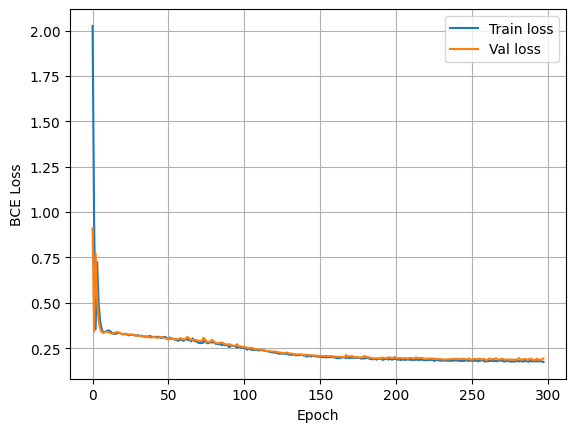

Test evaluation
AUC 0.9133457720465346
Top 10 False Positives:


KeyError: tensor(756)

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
h_feats = 24
model = GraphSAGE(train_graph.ndata["feat"].shape[1], h_feats).to(device)
predictor = MLPPredictor(h_feats).to(device)
#predictor = DotPredictor().to(device)
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), predictor.parameters()),
                             lr=0.01)
EPOCHS = 300
BATCH_SIZE = 512
loss_history = {'Train':[], 'Val':[]}
train_graph = train_graph.to(device)
test_graph = test_graph.to(device)
val_graph = val_graph.to(device)
for epoch in range(EPOCHS):
    model.train()
    # Forward
    h = model(train_graph, train_graph.ndata["feat"])
    pos_pred = predictor(train_pos_graph.to(device), h)
    neg_pred = predictor(train_neg_graph.to(device), h)
    loss = compute_loss(pos_pred, neg_pred, device)
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history['Train'].append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
      h = model(val_graph, val_graph.ndata["feat"])
      pos_pred = predictor(val_pos_graph.to(device), h)
      neg_pred = predictor(val_neg_graph.to(device), h)
      loss = compute_loss(pos_pred, neg_pred, device)
      loss_history['Val'].append(loss.item())

    if epoch%5 == 0:
        print(f"In epoch {epoch}, loss: {loss:.3f}")

plot_loss(loss_history)

# Prediction
model.eval()
with torch.no_grad():
    h = model(test_graph, test_graph.ndata["feat"])
    pos_pred = predictor(test_pos_graph.to(device), h)
    neg_pred = predictor(test_neg_graph.to(device), h)
    print("Test evaluation")
    print("AUC", compute_auc(pos_pred.cpu(), neg_pred.cpu()))


In [75]:
model.eval()
with torch.no_grad():
  h = model(test_graph, test_graph.ndata["feat"])
  topk_prediction_errors(test_pos_graph, test_neg_graph, h, predictor, device)


Top 10 sur les liens inexistants:
Lien (M178, M295) 
 Score: -39.6985, True Label: 0.0
----------------------------------------
Lien (M189, M295) 
 Score: -36.8209, True Label: 0.0
----------------------------------------
Lien (M189, B143) 
 Score: -36.7396, True Label: 0.0
----------------------------------------
Lien (M189, M114) 
 Score: -36.5100, True Label: 0.0
----------------------------------------
Lien (R12, B143) 
 Score: -36.2125, True Label: 0.0
----------------------------------------
Lien (M178, M79) 
 Score: -35.2011, True Label: 0.0
----------------------------------------
Lien (M186, M114) 
 Score: -34.2041, True Label: 0.0
----------------------------------------
Lien (A43, B143) 
 Score: -33.5699, True Label: 0.0
----------------------------------------
Lien (M229, M30) 
 Score: -32.8332, True Label: 0.0
----------------------------------------
Lien (M206, M260) 
 Score: -32.7916, True Label: 0.0
----------------------------------------

Top 10 sur les liens qui exi

In epoch 0, loss: 2.735
In epoch 5, loss: 0.550
In epoch 10, loss: 0.331
In epoch 15, loss: 0.328
In epoch 20, loss: 0.333
In epoch 25, loss: 0.327
In epoch 30, loss: 0.329
In epoch 35, loss: 0.324
In epoch 40, loss: 0.323
In epoch 45, loss: 0.319
In epoch 50, loss: 0.317
In epoch 55, loss: 0.312
In epoch 60, loss: 0.308
In epoch 65, loss: 0.303
In epoch 70, loss: 0.304
In epoch 75, loss: 0.301
In epoch 80, loss: 0.295
In epoch 85, loss: 0.299
In epoch 90, loss: 0.291
In epoch 95, loss: 0.290
In epoch 100, loss: 0.280
In epoch 105, loss: 0.281
In epoch 110, loss: 0.265
In epoch 115, loss: 0.266
In epoch 120, loss: 0.253
In epoch 125, loss: 0.248
In epoch 130, loss: 0.239
In epoch 135, loss: 0.233
In epoch 140, loss: 0.232
In epoch 145, loss: 0.231
In epoch 150, loss: 0.223
In epoch 155, loss: 0.220
In epoch 160, loss: 0.217
In epoch 165, loss: 0.213
In epoch 170, loss: 0.217
In epoch 175, loss: 0.212
In epoch 180, loss: 0.212
In epoch 185, loss: 0.208
In epoch 190, loss: 0.208
In epoch

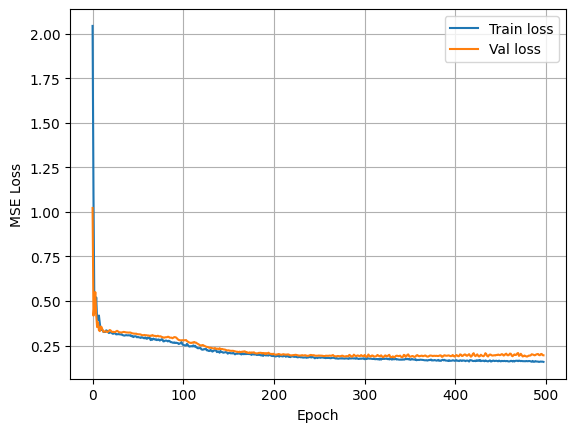

Test evaluation
AUC 0.9091145594642358
Top 10 erreurs de prédiction :

Erreur #1:
Lien (M36, M98)
Prédiction     = -70.4516
Étiquette vraie = 0
Erreur absolue = 70.4516
Incertitude élevée
----------------------------------------
Erreur #2:
Lien (M36, B16)
Prédiction     = -69.7799
Étiquette vraie = 0
Erreur absolue = 69.7799
Incertitude élevée
----------------------------------------
Erreur #3:
Lien (M36, M113)
Prédiction     = -66.2427
Étiquette vraie = 0
Erreur absolue = 66.2427
Incertitude élevée
----------------------------------------
Erreur #4:
Lien (M36, R152)
Prédiction     = -65.4149
Étiquette vraie = 0
Erreur absolue = 65.4149
Incertitude élevée
----------------------------------------
Erreur #5:
Lien (M203, M59)
Prédiction     = -63.6791
Étiquette vraie = 0
Erreur absolue = 63.6791
Incertitude élevée
----------------------------------------
Erreur #6:
Lien (M203, B247)
Prédiction     = -63.4979
Étiquette vraie = 0
Erreur absolue = 63.4979
Incertitude élevée
-----------------

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
h_feats = 24
model = GraphSAGE(train_graph.ndata["feat"].shape[1], h_feats).to(device)
predictor = MLPPredictor(h_feats).to(device)
#predictor = DotPredictor().to(device)
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), predictor.parameters()),
                             lr=0.01)
EPOCHS = 500
BATCH_SIZE = 512
loss_history = {'Train':[], 'Val':[]}
train_graph = train_graph.to(device)
test_graph = test_graph.to(device)
val_graph = val_graph.to(device)
for epoch in range(EPOCHS):
    model.train()
    # Forward
    h = model(train_graph, train_graph.ndata["feat"])
    pos_pred = predictor(train_pos_graph.to(device), h)
    neg_pred = predictor(train_neg_graph.to(device), h)
    loss = compute_loss(pos_pred, neg_pred, device)
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history['Train'].append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
      h = model(val_graph, val_graph.ndata["feat"])
      pos_pred = predictor(val_pos_graph.to(device), h)
      neg_pred = predictor(val_neg_graph.to(device), h)
      loss = compute_loss(pos_pred, neg_pred, device)
      loss_history['Val'].append(loss.item())

    if epoch%5 == 0:
        print(f"In epoch {epoch}, loss: {loss:.3f}")

plot_loss(loss_history)

# Prediction
model.eval()
with torch.no_grad():
    h = model(test_graph, test_graph.ndata["feat"])
    pos_pred = predictor(test_pos_graph.to(device), h)
    neg_pred = predictor(test_neg_graph.to(device), h)
    print("Test evaluation")
    print("AUC", compute_auc(pos_pred.cpu(), neg_pred.cpu()))

In [ ]:
model.eval()
with torch.no_grad():
  h = model(test_graph, test_graph.ndata["feat"])
  topk_prediction_errors(test_pos_graph, test_neg_graph, h, predictor, device)

In epoch 0, loss: 0.649
In epoch 5, loss: 0.503
In epoch 10, loss: 0.394
In epoch 15, loss: 0.312
In epoch 20, loss: 0.282
In epoch 25, loss: 0.296
In epoch 30, loss: 0.305
In epoch 35, loss: 0.291
In epoch 40, loss: 0.269
In epoch 45, loss: 0.252
In epoch 50, loss: 0.243
In epoch 55, loss: 0.237
In epoch 60, loss: 0.234
In epoch 65, loss: 0.231
In epoch 70, loss: 0.228
In epoch 75, loss: 0.225
In epoch 80, loss: 0.224
In epoch 85, loss: 0.223
In epoch 90, loss: 0.222
In epoch 95, loss: 0.221
In epoch 100, loss: 0.221
In epoch 105, loss: 0.220
In epoch 110, loss: 0.220
In epoch 115, loss: 0.219
In epoch 120, loss: 0.219
In epoch 125, loss: 0.218
In epoch 130, loss: 0.218
In epoch 135, loss: 0.218
In epoch 140, loss: 0.217
In epoch 145, loss: 0.216
In epoch 150, loss: 0.216
In epoch 155, loss: 0.215
In epoch 160, loss: 0.216
In epoch 165, loss: 0.215
In epoch 170, loss: 0.215
In epoch 175, loss: 0.214
In epoch 180, loss: 0.214
In epoch 185, loss: 0.214
In epoch 190, loss: 0.213
In epoch

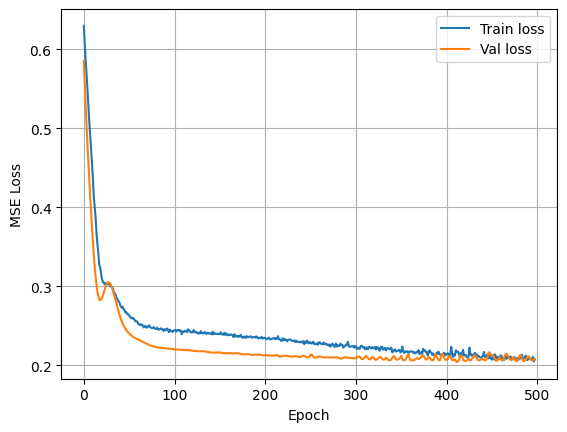

Test evaluation
AUC 0.9096996695317956


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
h_feats = 24
model = GCN(train_graph.ndata["feat"].shape[1], h_feats).to(device)
predictor = MLPPredictor(h_feats).to(device)
#predictor = DotPredictor().to(device)
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), predictor.parameters()),
                             lr=0.001)
EPOCHS = 500
BATCH_SIZE = 512
loss_history = {'Train':[], 'Val':[]}
train_graph = train_graph.to(device)
test_graph = test_graph.to(device)
val_graph = val_graph.to(device)
for epoch in range(EPOCHS):
    model.train()
    # Forward
    new_train_graph = suppress_zero_degree(train_graph)
    h = model(new_train_graph, train_graph.ndata["feat"])
    pos_pred = predictor(train_pos_graph.to(device), h)
    neg_pred = predictor(train_neg_graph.to(device), h)
    loss = compute_loss(pos_pred, neg_pred, device)
    # Backward
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loss_history['Train'].append(loss.item())

    # Validation
    model.eval()
    with torch.no_grad():
      new_val_graph = suppress_zero_degree(val_graph)
      h = model(new_val_graph, val_graph.ndata["feat"])
      pos_pred = predictor(val_pos_graph.to(device), h)
      neg_pred = predictor(val_neg_graph.to(device), h)
      loss = compute_loss(pos_pred, neg_pred, device)
      loss_history['Val'].append(loss.item())

    if epoch%5 == 0:
        print(f"In epoch {epoch}, loss: {loss:.3f}")

plot_loss(loss_history)

# Prediction
model.eval()
with torch.no_grad():
    new_test_graph = suppress_zero_degree(test_graph)
    h = model(new_test_graph, test_graph.ndata["feat"])
    pos_pred = predictor(test_pos_graph.to(device), h)
    neg_pred = predictor(test_neg_graph.to(device), h)
    print("Test evaluation")
    print("AUC", compute_auc(pos_pred.cpu(), neg_pred.cpu()))

In epoch 0, loss: 0.384
In epoch 5, loss: 0.165
In epoch 10, loss: 0.151
In epoch 15, loss: 0.143
In epoch 20, loss: 0.138
In epoch 25, loss: 0.133
In epoch 30, loss: 0.129
In epoch 35, loss: 0.128
In epoch 40, loss: 0.126
In epoch 45, loss: 0.123
In epoch 50, loss: 0.123
In epoch 55, loss: 0.120
In epoch 60, loss: 0.119
In epoch 65, loss: 0.119
In epoch 70, loss: 0.118
In epoch 75, loss: 0.117
In epoch 80, loss: 0.117
In epoch 85, loss: 0.117
In epoch 90, loss: 0.116
In epoch 95, loss: 0.116
In epoch 100, loss: 0.115
In epoch 105, loss: 0.115
In epoch 110, loss: 0.116
In epoch 115, loss: 0.114
In epoch 120, loss: 0.113
In epoch 125, loss: 0.114
In epoch 130, loss: 0.114
In epoch 135, loss: 0.115
In epoch 140, loss: 0.114
In epoch 145, loss: 0.114
In epoch 150, loss: 0.114
In epoch 155, loss: 0.113
In epoch 160, loss: 0.113
In epoch 165, loss: 0.113
In epoch 170, loss: 0.113
In epoch 175, loss: 0.113
In epoch 180, loss: 0.112
In epoch 185, loss: 0.113
In epoch 190, loss: 0.112
In epoch

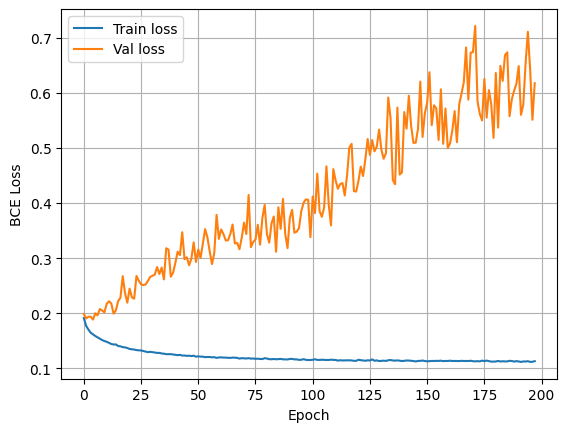

Test evaluation
AUC 0.8536595752798803


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
h_feats = 24
model = GraphSAGE(train_graph.ndata["feat"].shape[1], h_feats).to(device)
predictor = MLPPredictor(h_feats).to(device)
#predictor = DotPredictor().to(device)
optimizer = torch.optim.Adam(itertools.chain(model.parameters(), predictor.parameters()),
                             lr=0.01)
EPOCHS = 200
BATCH_SIZE = 512
loss_history = {'Train':[], 'Val':[]}
train_graph = train_graph.to(device)
test_graph = test_graph.to(device)
val_graph = val_graph.to(device)
for epoch in range(EPOCHS):
    model.train()
    train_dataloader = Dataloader_pos_neg_graph(train_pos_graph, train_neg_graph, BATCH_SIZE)
    total_train_loss = 0
    for batch_pos, batch_neg in train_dataloader:
        # Forward
        h = model(train_graph, train_graph.ndata["feat"])
        pos_pred = predictor(batch_pos.to(device), h[batch_pos.ndata[dgl.NID]])
        neg_pred = predictor(batch_neg.to(device), h[batch_neg.ndata[dgl.NID]])
        loss = compute_loss(pos_pred, neg_pred, device)
        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()
    loss_history['Train'].append(total_train_loss/train_dataloader.num_batches)

    # Evaluation on the validation set
    model.eval()
    with torch.no_grad():
      val_dataloader = Dataloader_pos_neg_graph(val_pos_graph, val_neg_graph, BATCH_SIZE)
      total_val_loss = 0
      for batch_pos, batch_neg in val_dataloader:
        h = model(val_graph, val_graph.ndata["feat"])
        pos_pred = predictor(batch_pos.to(device), h[batch_pos.ndata[dgl.NID]])
        neg_pred = predictor(batch_neg.to(device), h[batch_neg.ndata[dgl.NID]])
        loss = compute_loss(pos_pred, neg_pred, device)
        total_val_loss += loss.item()
      loss_history['Val'].append(total_val_loss/val_dataloader.num_batches)

    if epoch%5 == 0:
        print(f"In epoch {epoch}, loss: {total_train_loss/train_dataloader.num_batches:.3f}")

plot_loss(loss_history)

# Evaluation on the test set
model.eval()
with torch.no_grad():
    h = model(test_graph, test_graph.ndata["feat"])
    pos_pred = predictor(test_pos_graph.to(device), h)
    neg_pred = predictor(test_neg_graph.to(device), h)
    print("Test evaluation")
    print("AUC", compute_auc(pos_pred.cpu(), neg_pred.cpu()))